In [1]:
# save horizontal voting ensemble members during training
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from os import makedirs
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# create directory for models
makedirs('models')
# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
  # fit model for a single epoch
  model.fit(trainX, trainy, epochs=1, verbose=0)
  # check if we should save the model
  if i >= n_save_after:
    model.save('models/model_' + str(i) + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>loaded /content/models/model_950.h5
>loaded /content/models/model_951.h5
>loaded /content/models/model_952.h5
>loaded /content/models/model_953.h5
>loaded /content/models/model_954.h5
>loaded /content/models/model_955.h5
>loaded /content/models/model_956.h5
>loaded /content/models/model_957.h5
>loaded /content/models/model_958.h5
>loaded /content/models/model_959.h5
>loaded /content/models/model_960.h5
>loaded /content/models/model_961.h5
>loaded /content/models/model_962.h5
>loaded /content/models/model_963.h5
>loaded /content/models/model_964.h5
>loaded /content/models/model_965.h5
>loaded /content/models/model_966.h5
>loaded /content/models/model_967.h5
>loaded /content/models/model_968.h5
>loaded /content/models/model_969.h5
>loaded /content/models/model_970.h5
>loaded /content/models/model_971.h5
>loaded /content/models/model_972.h5
>loaded /content/models/model_973.h5
>loaded /content/models/model_974.h5
>loaded /content/models/model_975.h5
>loaded /content/models/model_976.h5
>

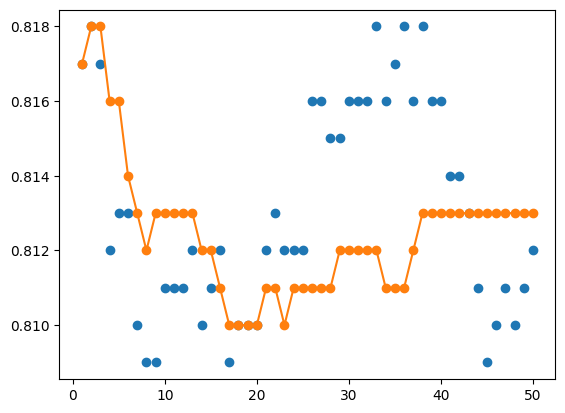

In [2]:
# load models and make predictions using a horizontal voting ensemble
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

# load models from file
def load_all_models(n_start, n_end):
  all_models = list()
  for epoch in range(n_start, n_end):
    # define filename for this ensemble
    filename = '/content/models/model_' + str(epoch) + '.h5'
    # load model from file
    model = load_model(filename)
    # add to list of members
    all_models.append(model)
    print('>loaded %s' % filename)
  return all_models

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
  ensemble_score = evaluate_n_members(members, i, testX, testy)
  # evaluate the i'th model standalone
  testy_enc = to_categorical(testy)
  _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
  # summarize this step
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()